# 1. Introduction

This notebook was written to process Porto Alegre Traffic Accidents Data provide by the city hall open data repository to create a model to predict the probability of injured people given some information about the event. In this way, this notebook will make cleaning and feature engineering for our model. It only has one basic data viz and a lot of text and tables. I will use my data viz skills in future work.

Before we begin, it is important to say that on the city hall portal you can download the data dictionary and it is also available in this folder.


# 2. Data Loading 

In [1]:
import holidays
import numpy as np
import pandas as pd
from load import get_data
from itertools import product

In [2]:
accidents = pd.DataFrame(get_data())

accidents.replace("", np.NaN, inplace=True)

accidents.to_csv("./accidents_raw.csv", index=False)

accidents.head(3).T

,0,1,2
_id,1,2,3
data_extracao,2022-09-01T01:34:30,2022-09-01T01:34:30,2022-09-01T01:34:30
predial1,0.0,2473.0,7221.0
queda_arr,0,0,0
data,2020-10-17T00:00:00,2017-01-01T00:00:00,2017-01-01T00:00:00
feridos,1,1,1
feridos_gr,0,0,0
mortes,0,0,0
morte_post,0,0,0
fatais,0,0,0


# 3. Data Cleaning

In [3]:
# Analyzing the date and time features
accidents[["data", "hora"]].dtypes

data    object
hora    object
dtype: object

In [4]:
# Parsing the date and time feataures
accidents["data"] = pd.to_datetime(accidents["data"], errors="coerce")
accidents["hora"] = pd.to_datetime(accidents["hora"], errors="coerce")

accidents[["data", "hora"]].dtypes

data    datetime64[ns]
hora    datetime64[ns]
dtype: object

In [5]:
# Removing accidents on future
data_extraction = pd.to_datetime(accidents["data_extracao"].unique()[0])

accidents = accidents[accidents["data"] < data_extraction]

In [6]:
def print_missing(df: pd.DataFrame) -> None:
    """This function will print the percentage
    of missing values"""
    # Missing values
    temp = accidents.isna().mean()
    display(temp[accidents.isna().mean() > 0])

`predial1`, `log1`, `log2`, and `consorcio` are not important for our model. However, `data`, `hora`, and `region` otherwise are important. Although they are not representative, we will drop these rows. Now, let’s analyze long and lat first.

In [7]:
accidents.dropna(subset=["data", "hora", "regiao"], inplace=True)

accidents.reset_index(drop=True, inplace=True)

print_missing(accidents)

predial1     0.009015
longitude    0.165836
latitude     0.165836
log1         0.000645
log2         0.709432
consorcio    0.960905
dtype: float64

In [8]:
col_geo = ["longitude", "latitude"]
accidents[col_geo].describe().style.format("{:.4f}")

,longitude,latitude
count,56905.0000,56905.0000
mean,-131237750.1205,206247062.7858
std,292467399.8474,478759583.3601
min,-831414582.0000,-301861333.0000
25%,-51.2285,-30.0578
50%,-51.2008,-30.0294
75%,-51.1669,-29.9999
max,0.0000,1298214440.0000


Something wird here. POA is geographic at -30.1087957,-51.317229. Let's clean this messy.

In [9]:
def clean_geo(df_raw: pd.DataFrame, col: str, coord: int) -> pd.Series:
    """This function will fill values that a geopoint
    with NaN and transform the remaning. It is designer to
    coordenates with 2 digits before dot."""
    temp = df_raw[col].copy()

    # Removing coordinates much bigger than expected
    mask = temp.astype("str").str[0] != str(coord)[0]  # Picking number outside the coordenate
    temp[mask] = np.NaN

    digits = int(len(str(coord)))

    temp2 = (temp[~mask].astype("str").str[:digits] + "." + 
                temp[~mask].astype("str").str[(digits+1):-2])

    temp[~mask] = temp2.astype("float")

    # removing coodinates no mich bigger than expected
    mask = temp.between(coord-2, coord+2)
    temp[~mask] = np.NaN

    return temp

In [10]:
accidents["longitude"] = clean_geo(accidents, "longitude", -51)

accidents["latitude"] = clean_geo(accidents, "latitude", -30)

accidents[col_geo].describe().style.format("{:.5f}")

,longitude,latitude
count,48380.00000,47013.00000
mean,-51.19628,-30.04948
std,0.09136,0.06032
min,-51.99994,-30.98493
25%,-51.21538,-30.06480
50%,-51.19231,-30.03781
75%,-51.15965,-30.01608
max,-51.00166,-29.74211


The missing value in long and lat increase. However, we can use `regiao` to fill this gap. We could use the address with an API, such GoogleMaps or OpenStreetMap. We may also use the address inside the dataset; however, these two options will be on the next versions.

In [11]:
def fill_geo(
    df_raw: pd.DataFrame,
    cols: list,
    index: str) -> pd.DataFrame:
    """This function will impute missing values on
    geo coordenates based on a column to extract
    mean value."""

    df = df_raw.copy()

    df_fill = df.dropna()

    df_fill = df_fill.groupby("regiao", as_index=False)[col_geo].agg(np.mean)

    df_fill = df[["regiao"]].merge(df_fill)

    df = df.combine_first(df_fill)

    return df

In [12]:
accidents = fill_geo(accidents, col_geo, "regiao")

accidents[col_geo].describe().style.format("{:.5f}")

,longitude,latitude
count,68218.00000,68218.00000
mean,-51.19647,-30.05403
std,0.07733,0.05254
min,-51.99994,-30.98493
25%,-51.21698,-30.06409
50%,-51.18839,-30.05580
75%,-51.17685,-30.02400
max,-51.00166,-29.74211


In [13]:
print_missing(accidents)

consorcio    0.960905
log1         0.000645
log2         0.709432
predial1     0.009015
dtype: float64

In [14]:
col = ["data",
       "hora",
       "latitude",
       "longitude",
       "tipo_acid",
       "feridos",
       "feridos_gr",
       "fatais"]

vehicles = ["auto",
            "taxi",
            "lotacao",
            "onibus_urb",
            "onibus_met",
            "onibus_int",
            "caminhao",
            "moto",
            "carroca",
            "bicicleta",
            "outro",
            "patinete"]

accidents_clean = accidents.loc[:, col+vehicles].copy()

accidents_clean.to_csv("./accidents_clean.csv", index=False)

# 4. Data Processing

Let's find some incoherent events. The next table present on the below the diagonal incoherent values (rows == True e columns == False). On the other side, coherent values.

In [15]:
col_class = ["feridos", "feridos_gr", "fatais"]

acc_tab = accidents_clean.loc[:, col_class].copy()

acc_tab = acc_tab > 0

acc_tab_value = []

for i, j in [*product(col_class,col_class)]:
    acc_tab_value.append((acc_tab[i] & ~acc_tab[j]).sum())

acc_tab = pd.DataFrame(
    np.reshape(np.array(acc_tab_value), (3,3)),
    index=col_class,
    columns=col_class)

display(acc_tab)

,feridos,feridos_gr,fatais
feridos,0,19980,25079
feridos_gr,6,0,5137
fatais,346,378,0


There are two important facts to talk about. Let’s begin with the incoherent ones. There is a very small amount (around 1% of our data) of incoherent events. However, if we drop them, the number of fatal accidents decrease a lot. In this way, we will force a constrained top to down.

In [16]:
accidents_clean.loc[:, col_class] = accidents_clean.loc[:, col_class] > 0

In [17]:
mask = (accidents_clean["feridos_gr"]) | accidents_clean["fatais"]

accidents_clean["feridos_gr"] = mask

In [18]:
mask = (accidents_clean["feridos"]) | accidents_clean["feridos_gr"]

accidents_clean["feridos"] = mask

Let's see a big picture about the accidents in Porto Alegre.

In [19]:
acc_total = accidents_clean.shape[0]

acc_inj_wo = (~accidents_clean["feridos"]).sum()

acc_inj = (accidents_clean["feridos"] & ~accidents_clean["feridos_gr"]).sum()

acc_inj_serius = (accidents_clean["feridos_gr"] & ~accidents_clean["fatais"]).sum()

acc_inj_death = (accidents_clean["fatais"]).sum()

year_start = accidents["data"].min().year

year_end = accidents["data"].max().year

print(f"We had {acc_total} traffic accidents between {year_start} and {year_end}, with the following distribution:")
print(f"- {acc_inj_wo} accidents without injured people;")
print(f"- {acc_inj} accidents with injured people;")
print(f"- {acc_inj_serius} accidents with seriously injured people; and")
print(f"- {acc_inj_death} accidents with dead people (on the event or after it).")

We had 68218 traffic accidents between 2017 and 2022, with the following distribution:
- 42721 accidents without injured people;
- 19943 accidents with injured people;
- 5137 accidents with seriously injured people; and
- 417 accidents with dead people (on the event or after it).


Let's see a quick plot with accidents by month in this period.

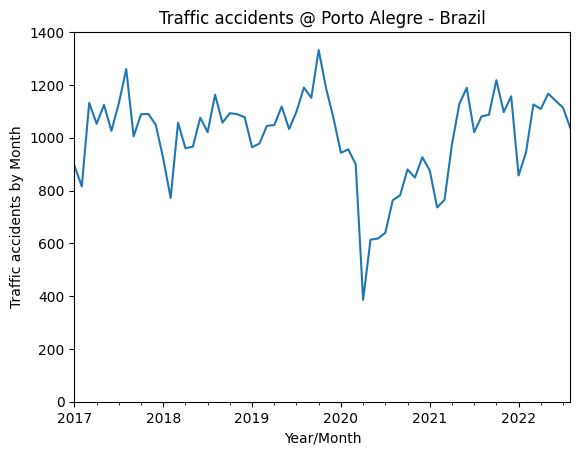

In [20]:
acc_dates = accidents["data"].sort_values()

acc_dates = acc_dates.dt.to_period('M')

acc_dates.value_counts(sort=False).plot(
    title="Traffic accidents @ Porto Alegre - Brazil",
    ylim=(0,1400),
    xlabel="Year/Month",
    ylabel="Traffic accidents by Month");

We see a big decrease in 2020 due to the pandemic period. However, the number of events returns to the same level as before.

Let's now analyze the types of vehicles involved.

In [21]:
accidents_clean[vehicles] = accidents_clean[vehicles] > 0

accidents_clean[vehicles].mean(axis=0)

auto          0.895849
taxi          0.031590
lotacao       0.012533
onibus_urb    0.041617
onibus_met    0.006802
onibus_int    0.009396
caminhao      0.089580
moto          0.267437
carroca       0.000308
bicicleta     0.018851
outro         0.002023
patinete      0.000015
dtype: float64

Some features are rare cases (less than 1%). In this way, to prevent some trouble, let's group them into:

- cars: auto and taxi;

- transport: lotacao, onibus_urb, onibus_met, onibus_int;

- caminhao (cargo);

- moto (motorcycle);

- others (carroca, bicicleta, outro, patinete).

In [22]:
cols = ["auto", "taxi"]
accidents_clean["cars"] = accidents_clean[cols].any(axis=1)

cols = ["lotacao", "onibus_urb", "onibus_met", "onibus_int"]
accidents_clean["transport"] = accidents_clean[cols].any(axis=1)

cols = ["carroca", "bicicleta", "outro", "patinete"]
accidents_clean["others"] = accidents_clean[cols].any(axis=1)

cols_remove = ["auto", "taxi"] + ["lotacao", "onibus_urb", "onibus_met", "onibus_int"] + ["carroca", "bicicleta", "outro", "patinete"]

accidents_clean.drop(cols_remove, axis=1, inplace=True)

Let's add a new feature about holidays. As you may know, on holidays more people are free to travel. This causes an increase in traffic accidents.

In [23]:
# https://pt.stackoverflow.com/questions/439120/calend%C3%A1rios-brasileiros-utilizando-pandas-python?newreg=7c1f9480e9f5483faf1f3b764fcb14e2
# Importing holidays in Brazil and Rio Grande do Sul
holidays_br_rs = holidays.Brazil() + holidays.RS()

# Starting the engine of holidays
str(accidents_clean["data"].min()) in holidays_br_rs
str(accidents_clean["data"].max()) in holidays_br_rs
holidays_br_rs_list = pd.to_datetime([feriado for feriado in holidays_br_rs])

accidents_clean["holiday"] = accidents_clean["data"].isin(holidays_br_rs_list)

We will start now to transform our data to use into machine learning models.

In [24]:
accidents_process = accidents_clean.copy()

accidents_process.to_csv("./accidents_process.csv", index=False)

In [25]:
accidents_process["day_of_week"] = accidents_process["data"].dt.day_of_week
accidents_process.drop(columns=["data"], axis=1, inplace=True)

accidents_process["hour"] = accidents_process["hora"].dt.hour

accidents_process.drop(columns=["hora"], axis=1, inplace=True)

accidents_process = pd.get_dummies(
                        accidents_process,
                        columns=["day_of_week", "hour"],
                        prefix=["day", "hour"],
                        drop_first=True)

In [26]:
# Dealing with rare cases in accident type
acc_type = accidents_process["tipo_acid"].value_counts(normalize=True)

acc_rare = acc_type[acc_type < 0.05]

acc_list = acc_rare.index.to_list()

mask = accidents_process["tipo_acid"].isin(acc_list)
accidents_process.loc[mask, "tipo_acid"] = "OUTROS"

In [27]:
accidents_process = pd.get_dummies(
                        accidents_process,
                        columns=["tipo_acid"],
                        prefix=["type"],
                        drop_first=True)

Let's take a view of our transformed data.

In [28]:
accidents_process.head().T

,0,1,2,3,4
latitude,-30.009614,-30.0403,-30.069,-30.2198,-30.028
longitude,-51.185581,-51.1958,-51.1437,-51.0987,-51.2281
feridos,True,True,True,True,True
feridos_gr,False,False,False,False,False
fatais,False,False,False,False,False
caminhao,False,False,False,False,False
moto,True,True,False,False,True
cars,True,True,True,True,False
transport,False,False,False,False,False
others,False,False,False,False,False


Our work is done: data is ready to use in our modeling section. We will save the dataset and the following task will be done in the next notebook.

In [29]:
accidents_trans = accidents_process.copy()

accidents_trans.to_csv("./accidents_trans.csv", index=False)